# Scaling Python with Azure ML and Dask

![Describe gif](media/describe.gif)

## Environment setup

This notebook assumes you are using an Azure ML Compute Instance with the default kernel `azureml_py36`. This contains many unneccesary packages. If you want to avoid a long image build time, you may want to create a new conda environment with the minimal packages needed for your scenario. 

It is important that the local environment matches the remote environment to avoid mismatch issues when submitting commands to the remote cluster. To help with this, we will use Azure ML Environments. 

In [ ]:
pip install --upgrade dask[complete] adlfs lz4 distributed fastparquet pyarrow azureml-sdk[notebooks]

In [ ]:
pip uninstall azureml-samples -y

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML('<script>Jupyter.notebook.kernel.restart()</script>')

In [ ]:
# this is for a strange bug with compute instances 
import os

os.system('sudo cp /etc/nginx/nginx.conf setup/temp.conf') # stupid

nginx = ''

with open('setup/temp.conf') as f:
    for line in f.readlines():
        if 'websocket/|/ws/' in line:
            nginx += line.replace('websocket/|/ws/', 'websocket/|/ws')
        else:
            nginx += line
       
with open('setup/temp2.conf', 'w') as f:
    f.write(nginx)
    
os.system('sudo mv setup/temp2.conf /etc/nginx/nginx.conf')
os.system('sudo service nginx restart')
os.system('rm setup/temp.conf');

## Imports

Import all packages used in this notebook.

In [1]:
import os
import sys
import dask
import glob
import time
import socket
import matplotlib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from IPython.core.display import HTML

from azureml.widgets import RunDetails
from azureml.train.estimator import Estimator
from azureml.core.runconfig import MpiConfiguration
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.core import Workspace, Experiment, Dataset, Environment

%matplotlib inline 

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception cannot import name '_DistributedTraining'.


## Azure ML setup

Get the workspace.

In [2]:
ws = Workspace.from_config()
ws

Workspace.create(name='mediumdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copeters-rg')

### Data access setup

This is for a ADLS gen2 account I have provisioned with data. It should be read-able publicly.

You **should not** keep storage account keys in plain text format, and you definitely should not upload them to github in a public repo. 

Use the keyvault with the workspace through the Python SDK or Azure Portal to set the account name and key for your storage account, and use the keyvault to retrieve the secrets and pass them through. 

In [3]:
keyvault = ws.get_default_keyvault()
keyvault.set_secret('daskdataaccount', 'data4dask')
keyvault.set_secret('daskdatakey', 'V1a2dz8bOH+zXsOXk9YbkJGFxabjlLffXLeQ0+sGh4+vsT79fgPyAU/TNkQOg10Vt7NxqRT8I/9iftiwcfqXHA==')

In [4]:
STORAGE_OPTIONS = {
    'account_name': keyvault.get_secret('daskdataaccount'), 
    'account_key' : keyvault.get_secret('daskdatakey')
}

abfs_path = 'abfs://datasets/noaa/isd'

### Create environment 

Create the environment to be used on the remote cluster. 

In [5]:
env_name = 'dask-env'

if env_name not in ws.environments:
    env = Environment.from_existing_conda_environment(env_name, 'azureml_py36')
    env.python.conda_dependencies.add_pip_package('mpi4py') # needed for remote cluster
    env = env.register(ws)
else:
    env = ws.environments[env_name]
    
env.name, env.version

('dask-env', '1')

### Create VM pool

Create Azure ML VM pool for creating remote dask cluster(s).

In [6]:
pool_name = 'raspberrypis'

if pool_name not in ws.compute_targets:
    # create config for Azure ML cluster
    # change properties as needed
    config = AmlCompute.provisioning_configuration(
             vm_size                       = 'STANDARD_DS13_V2',  # 8 vCPUS 56 GB RAM 112 GB disk 
             max_nodes                     = 100,
             vnet_resourcegroup_name       = ws.resource_group,   # replace if needed
             vnet_name                     = 'vnet-vnet',    # replace if needed
             subnet_name                   = 'default',           # replace if needed
             idle_seconds_before_scaledown = 300
    )
    ct = ComputeTarget.create(ws, pool_name, config)
    ct.wait_for_completion(show_output=True)    
else:
    ct = ws.compute_targets[pool_name]
    
ct

AmlCompute(workspace=Workspace.create(name='mediumdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copeters-rg'), name=raspberrypis, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/copeters-rg/providers/Microsoft.MachineLearningServices/workspaces/mediumdata/computes/raspberrypis, type=AmlCompute, provisioning_state=Succeeded, location=northcentralus, tags=None)

## Startup cluster

Start the run now. The first time, this will take 

In [7]:
exp_name   = 'dask-prep'

script_params = {
    '--datastore': ws.get_default_datastore(),
    #'--script'   : 'run.py' # run code in run.py on cluster and teardown (batch processing)
}

est = Estimator('setup', 
                compute_target          = ct, 
                entry_script            = 'start.py',          # sets up Dask cluster
                environment_definition  = env,                 # use same env as local
                script_params           = script_params,       
                node_count              = 60,                  # 20 nodes -> 160 vCPUs, 1 TB RAM
                distributed_training    = MpiConfiguration()
               )

run = next(ws.experiments[exp_name].get_runs()) # use this to get existing run (if kernel restarted, etc)
#run = Experiment(ws, exp_name).submit(est)
run

WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.


Experiment,Id,Type,Status,Details Page,Docs Page
dask-interactive,dask-interactive_1578426042_cd0d96e1,azureml.scriptrun,Failed,Link to Azure Machine Learning studio,Link to Documentation


## Dataset overview

This uses an [Azure Open Dataset](https://azure.microsoft.com/services/open-datasets/catalog/) of [NOAA Integrated Surface Data (ISD)](https://azure.microsoft.com/services/open-datasets/catalog/noaa-integrated-surface-data/) containing worldwide hourly weather data such as temperature, precipitation, and wind. 

Expanded in memory, the full dataset is ~660 GB. It is stored in compressed parquet files in a blob container partitioned by year and month. The dataset is updated daily. Compressed, the files for the dataset are ~8 GB. Uncompressed, the files for the dataset are ~150-200 GB.  

Specific years and months can be specified by `year=*/month=*/part-*.snappy.parquet`. 

The data begins in 2008 and contains 1 file per month. Each file can contain ~5 GB of data when in a dataframe in memory.

## Pandas

In [8]:
abfs_path

'abfs://datasets/noaa/isd'

In [9]:
# adjust months as needed
m1 = 1
m2 = 3
# get list of files to read
files = [f'{abfs_path}/year=2019/month={m}/*.parquet' for m in range(m1, m2+1)]
# use dask to read from abfs, convert to pandas 
%time df = dd.read_parquet(files, engine='pyarrow', storage_options=STORAGE_OPTIONS).compute()

CPU times: user 19.4 s, sys: 7.58 s, total: 27 s
Wall time: 40.3 s


In [10]:
type(df) # confirm it's Pandas not Dask 

pandas.core.frame.DataFrame

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32856415 entries, 0 to 11120197
Data columns (total 22 columns):
usaf                       object
wban                       object
datetime                   datetime64[ns]
latitude                   float64
longitude                  float64
elevation                  float64
windAngle                  float64
windSpeed                  float64
temperature                float64
seaLvlPressure             float64
cloudCoverage              object
presentWeatherIndicator    float64
pastWeatherIndicator       float64
precipTime                 float64
precipDepth                float64
snowDepth                  float64
stationName                object
countryOrRegion            object
p_k                        object
year                       int32
day                        int32
version                    float64
dtypes: datetime64[ns](1), float64(13), int32(2), object(6)
memory usage: 5.4+ GB


In [12]:
%time len(df)

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 19.6 µs


32856415

In [13]:
%time df.describe()

CPU times: user 17.2 s, sys: 4.8 s, total: 22 s
Wall time: 22 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,3.285642e+07,3.285642e+07,3.285642e+07,2.737103e+07,2.830008e+07,3.214719e+07,1.312654e+07,4.127135e+06,1.225663e+06,8.103505e+06,8.103505e+06,365951.000000,32856415.0,3.285642e+07,32856415.0
mean,3.636384e+01,-3.717028e+01,3.906849e+02,1.726250e+02,3.676873e+00,4.585060e+00,1.016144e+03,4.014241e+01,4.181772e+00,1.519034e+01,2.275987e+03,26.477517,2019.0,1.550101e+01,1.0
std,2.318415e+01,7.814036e+01,7.242126e+02,1.157004e+02,3.072554e+00,1.337377e+01,1.086895e+01,3.052282e+01,2.961840e+00,2.991428e+01,4.182790e+03,29.773343,0.0,8.723274e+00,0.0
min,-9.000000e+01,-1.799830e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.988000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2019.0,1.000000e+00,1.0
25%,3.278200e+01,-9.555600e+01,3.600000e+01,7.000000e+01,1.500000e+00,-3.000000e+00,1.010300e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000,2019.0,8.000000e+00,1.0
50%,4.121700e+01,-7.543300e+01,1.780000e+02,1.800000e+02,3.100000e+00,4.000000e+00,1.016400e+03,5.100000e+01,4.000000e+00,1.000000e+00,0.000000e+00,20.000000,2019.0,1.500000e+01,1.0
75%,4.845000e+01,1.568600e+01,4.300000e+02,2.700000e+02,5.100000e+00,1.300000e+01,1.023100e+03,7.100000e+01,7.000000e+00,1.200000e+01,6.000000e+01,43.000000,2019.0,2.300000e+01,1.0
max,8.365600e+01,1.797500e+02,9.999000e+03,3.600000e+02,8.800000e+01,6.150000e+01,1.089500e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,697.000000,2019.0,3.100000e+01,1.0


In [14]:
%time bites = df.memory_usage(index=True, deep=True).sum()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 13.6 s, sys: 21.3 ms, total: 13.6 s
Wall time: 13.6 s
Dataframe is: 16.0GB


In [15]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean()
means.head()

CPU times: user 2.21 s, sys: 840 ms, total: 3.05 s
Wall time: 3.05 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2019-01-01,36.281951,-37.040627,392.396704,188.552802,4.044324,4.391837,1017.214198,40.251434,4.295040,15.533651,2300.457644,14.674692,2019,1,1.0
2019-01-02,36.369198,-37.290084,384.415207,175.098038,3.546742,3.250356,1018.311258,41.647164,4.646093,15.166829,2288.816866,16.738155,2019,2,1.0
2019-01-03,36.234547,-37.245756,384.442712,176.419014,3.390573,4.073418,1017.700144,42.984876,4.553081,14.486512,2214.186560,17.179716,2019,3,1.0
2019-01-04,36.291708,-36.901728,381.026500,178.444538,3.298544,4.891948,1016.072151,39.800114,4.571939,14.999360,2268.404353,17.323634,2019,4,1.0
2019-01-05,36.403439,-36.794582,384.924976,180.592511,3.155102,4.689213,1015.744552,38.390121,4.646371,15.530488,2268.322695,19.368870,2019,5,1.0


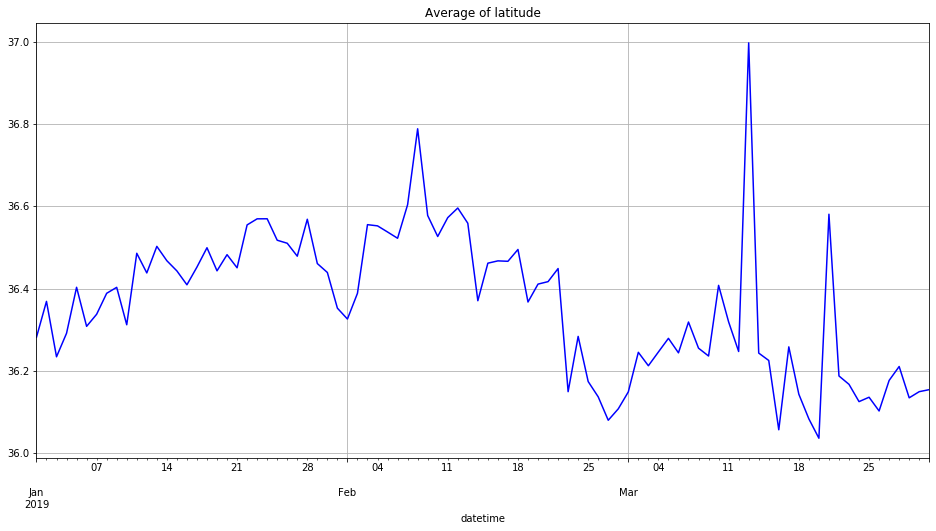

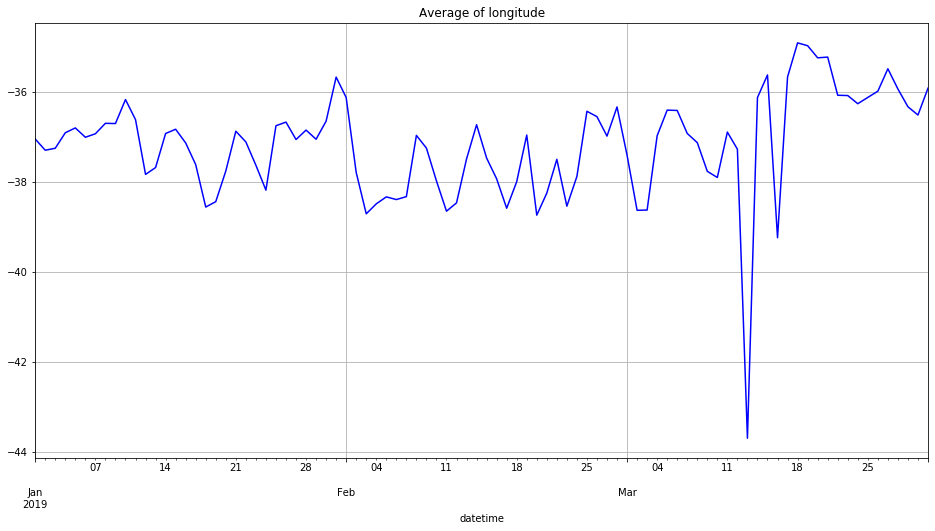

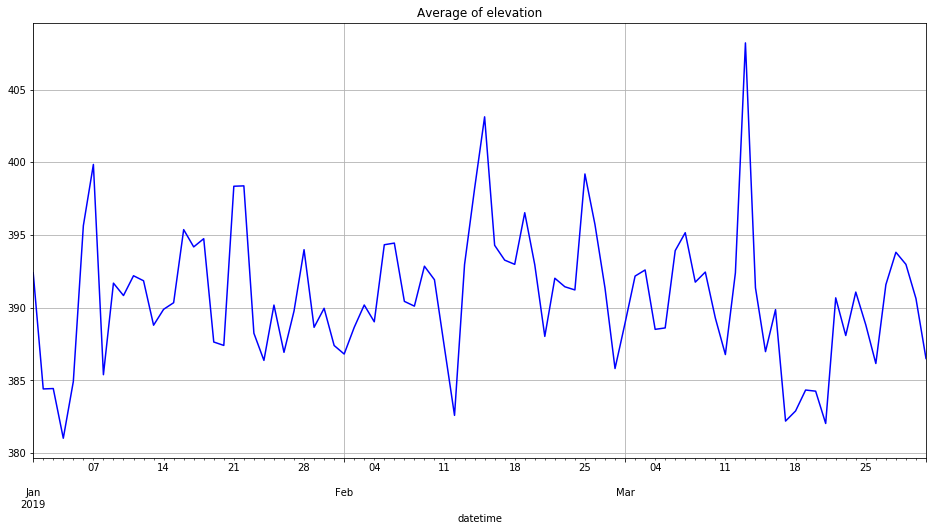

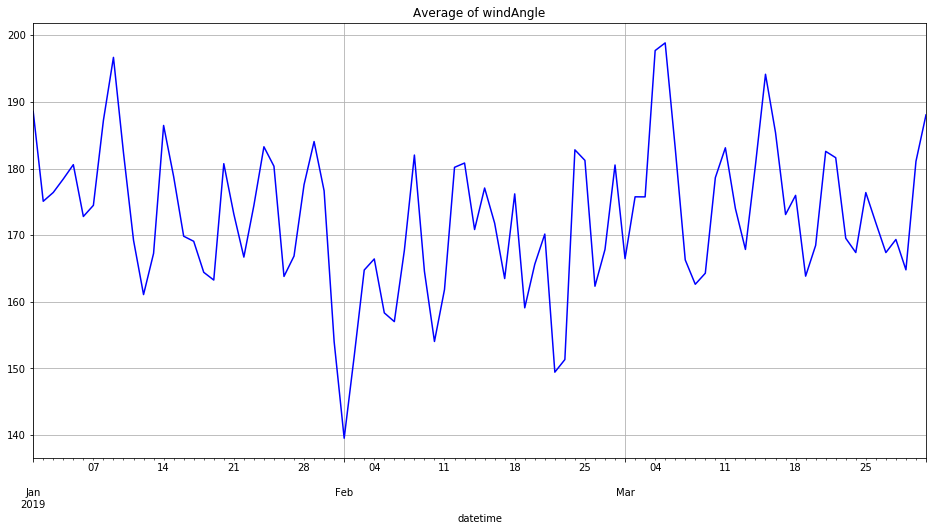

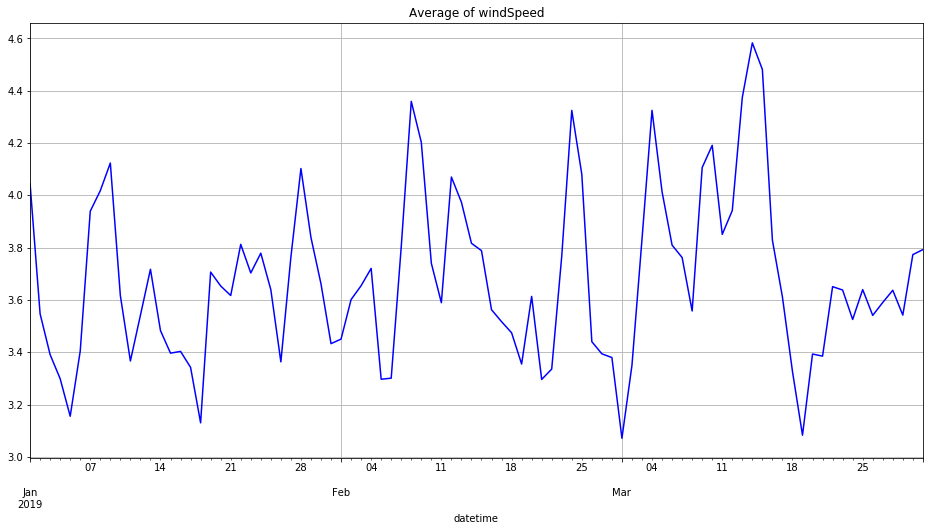

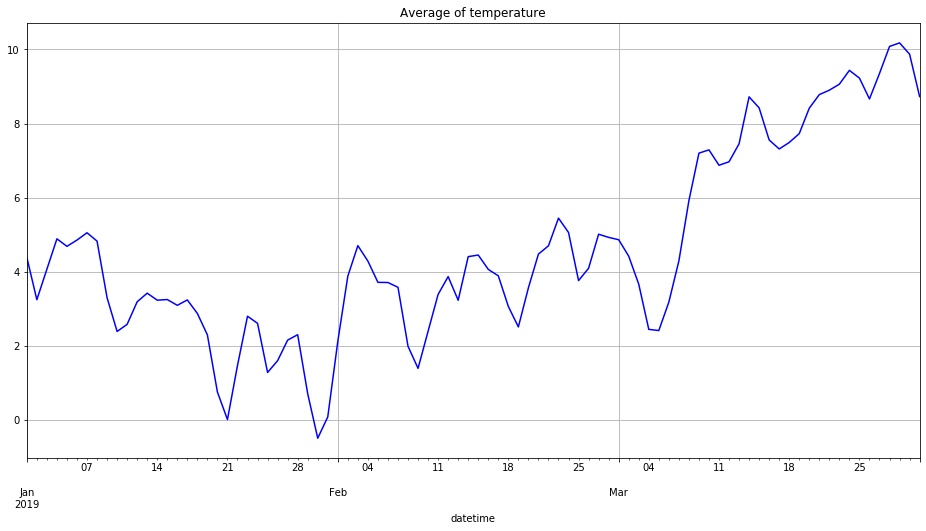

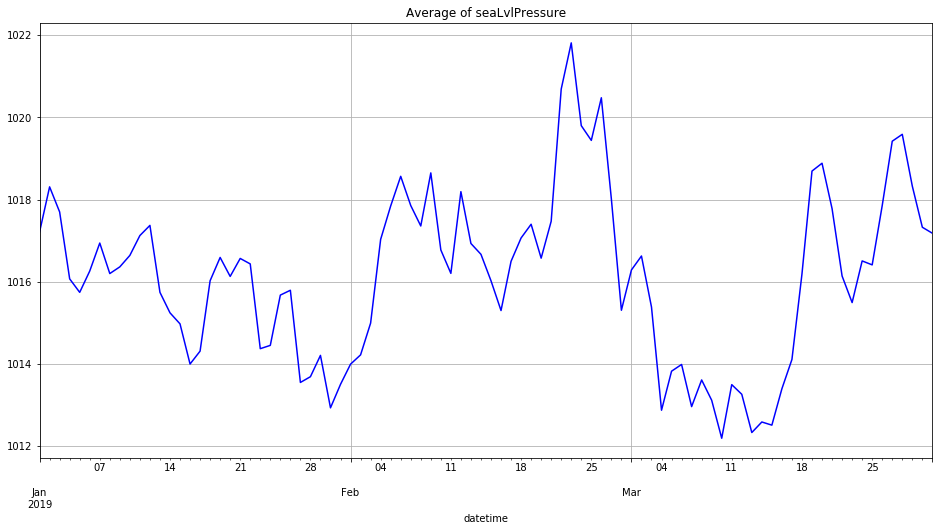

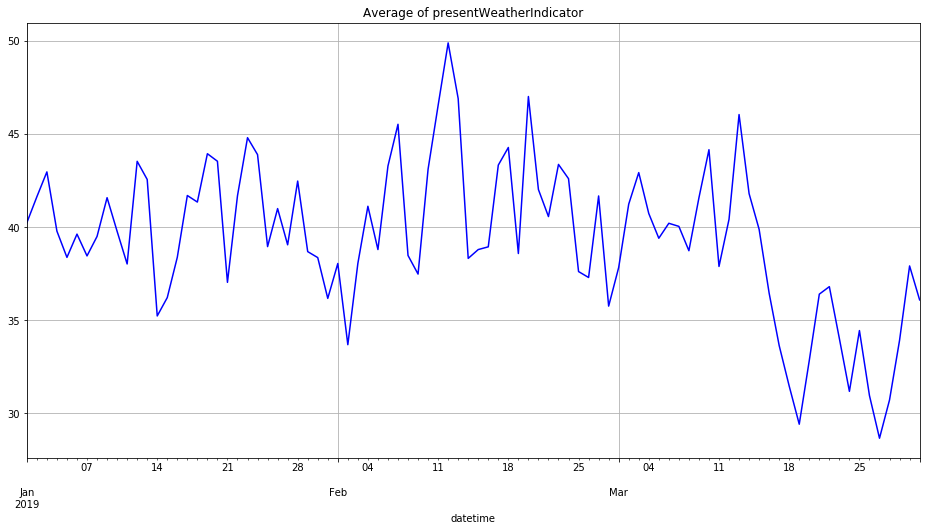

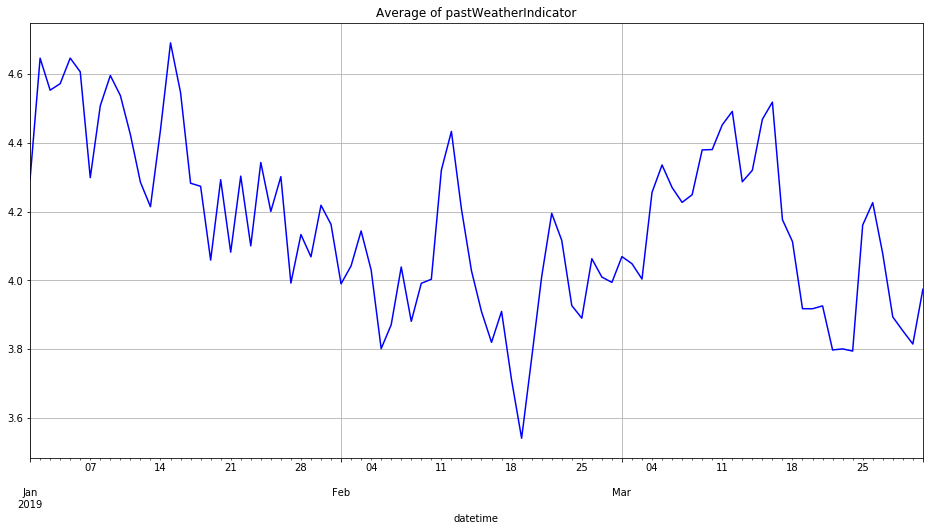

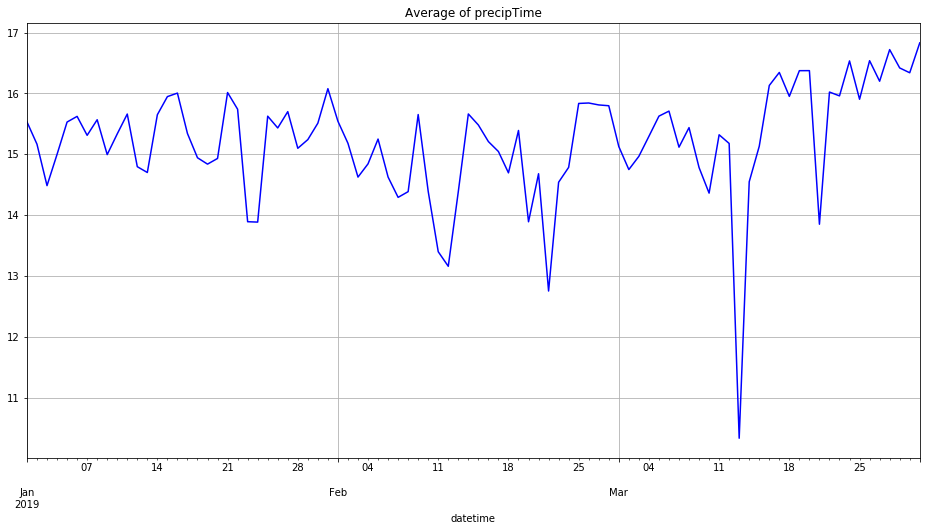

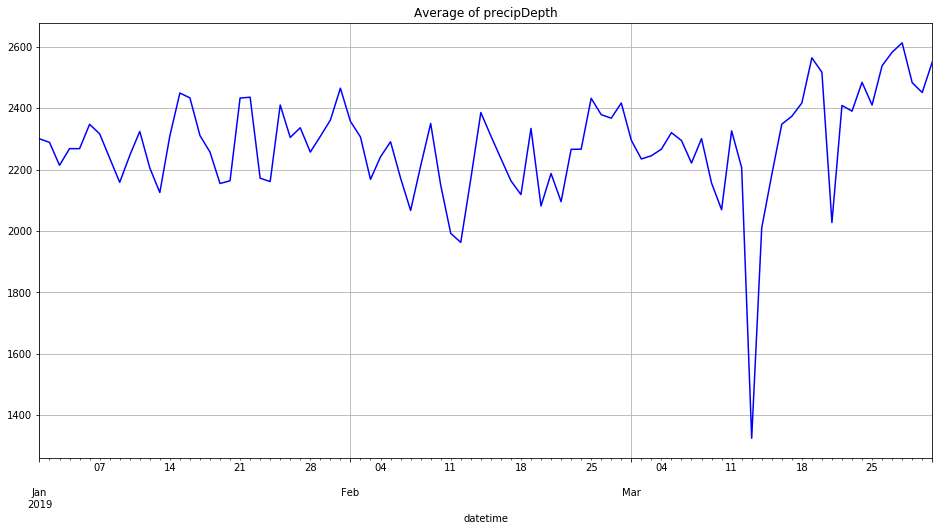

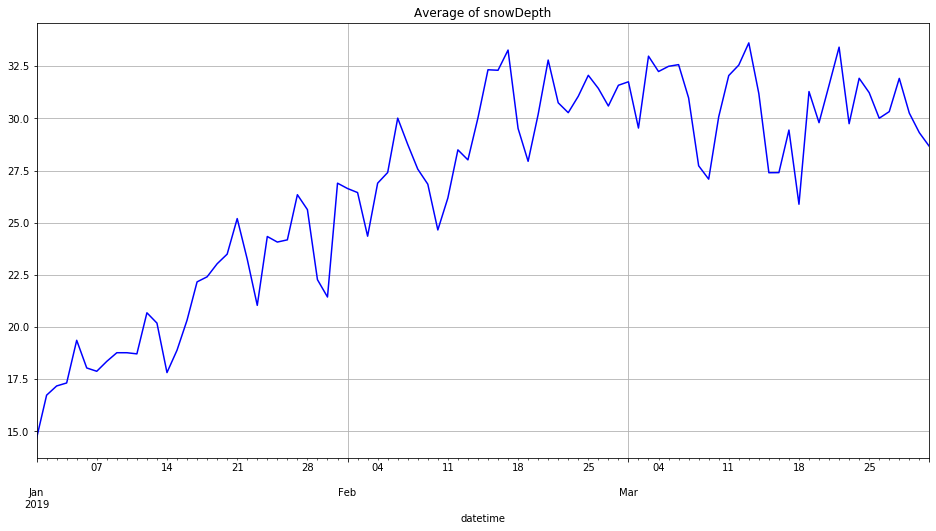

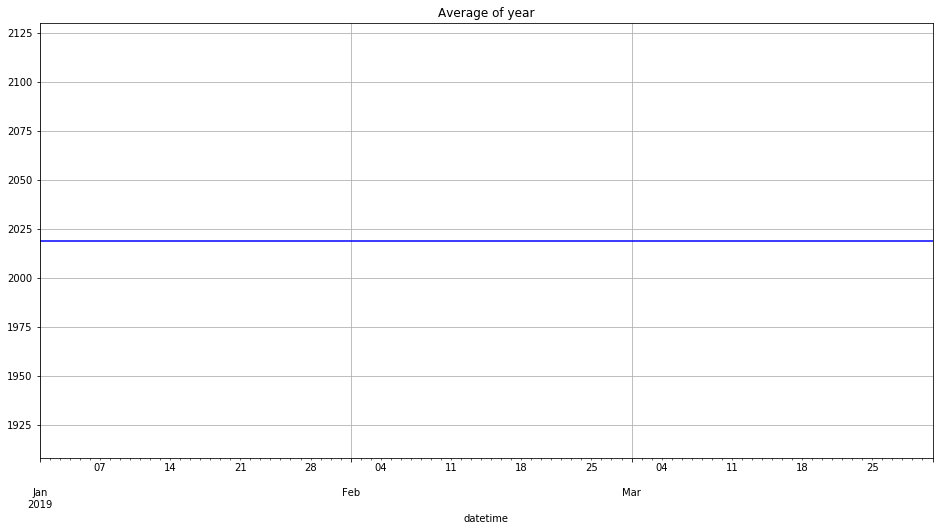

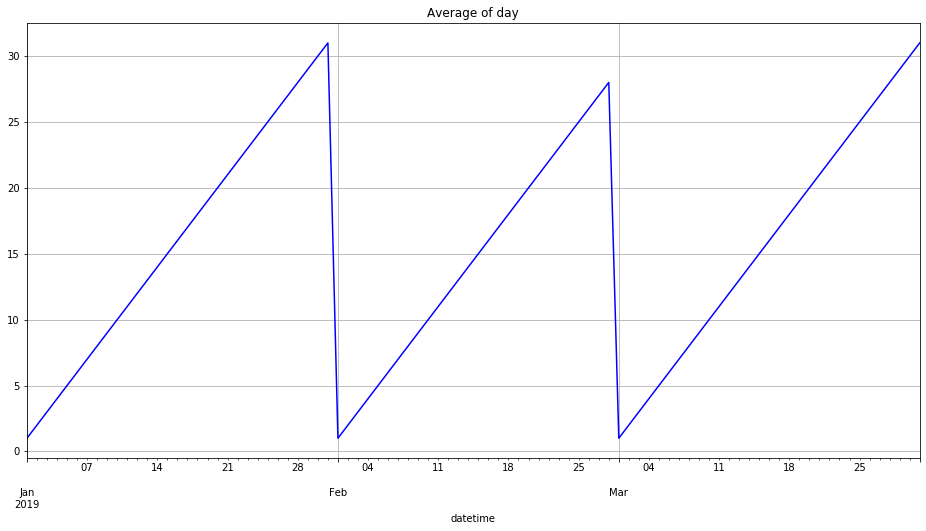

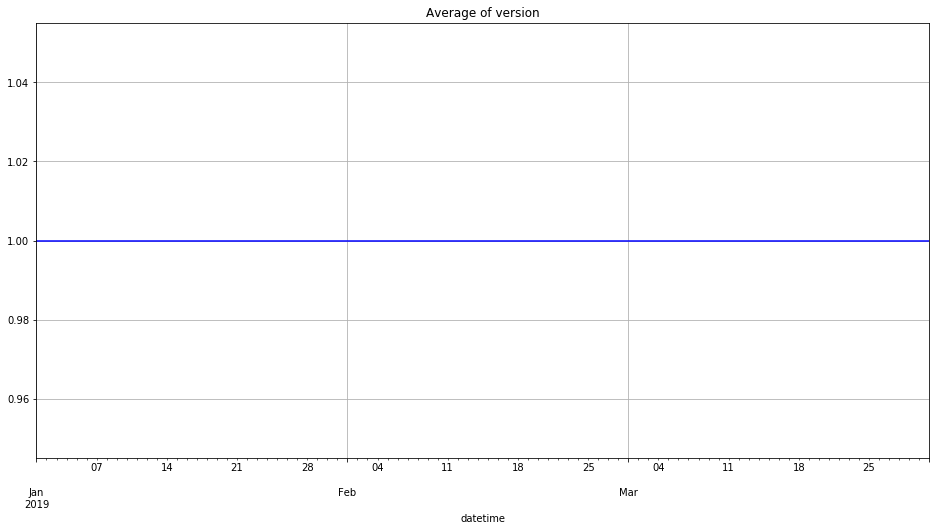

In [16]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2019, m1, 1), datetime(2019, m2+1, 1)])
    plt.grid()

## Scaling with Dask 'locally'

The first step in scaling up with Dask is to simply get a bigger VM. For non-GPU Compute Instances, the max is the `STANDARD_DS15_V2` with 20 cores and 140 GB of RAM. This is suitable for interactive querying and data preparation on about 1 year of the weather data, but not on the full dataset.

In [17]:
dashboard_port = 4444

# start the distributed scheduler 
c = Client(dashboard_address=f':{dashboard_port}')
print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')



<Client: 'tcp://127.0.0.1:45881' processes=6 threads=24, memory=236.64 GB>


### Take some data

Take some data. The below cells may fail on smaller VMs. 1 year works semi-reliably on a `STANDARD_DS15_V2`, although computing the means fails sometimes.

You can use the dashboard to understand what is going on with this VM being used as a "local" cluster. 

In [18]:
# adjust amount of data as needed
y1 = 2019
y2 = 2019
# build list of files 
files = [f'{abfs_path}/year={year}/month={m}/*.parquet' for year in range(y1, y2+1) for m in range(1, 12+1)]
# read into dask dataframe
df = dd.read_parquet(files, engine='pyarrow', storage_options=STORAGE_OPTIONS)
%time df.head()

CPU times: user 435 ms, sys: 89.1 ms, total: 524 ms
Wall time: 8.6 s


,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,717250,99999,2017-01-01 00:00:00,48.050,-77.767,337.0,80.0,3.6,-14.2,1004.4,...,NaN,24.0,9999.0,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
1,717250,99999,2017-01-01 00:00:00,48.053,-77.783,337.0,80.0,3.6,-14.0,1004.3,...,NaN,NaN,NaN,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
2,717250,99999,2017-01-01 01:00:00,48.053,-77.783,337.0,80.0,3.1,-14.0,1004.0,...,NaN,NaN,NaN,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
3,717250,99999,2017-01-01 02:00:00,48.053,-77.783,337.0,80.0,2.6,-14.0,1003.5,...,NaN,NaN,NaN,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
4,717250,99999,2017-01-01 03:00:00,48.050,-77.767,337.0,50.0,2.1,-14.2,1003.2,...,NaN,3.0,9999.0,NaN,VAL D OR,CA,717250-99999,2017,1,1.0


In [19]:
%time len(df)

CPU times: user 426 ms, sys: 68.2 ms, total: 494 ms
Wall time: 4.74 s


253228861

In [20]:
%time df.describe().compute()

CPU times: user 12.8 s, sys: 1.35 s, total: 14.1 s
Wall time: 1min 9s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,2.532289e+08,2.532289e+08,2.532289e+08,2.091104e+08,2.173500e+08,2.486149e+08,9.888802e+07,2.274568e+07,8.802492e+06,6.191478e+07,6.191478e+07,2.129887e+06,2.532289e+08,2.532289e+08,253228861.0
mean,3.644910e+01,-3.599169e+01,3.785063e+02,1.663294e+02,3.401879e+00,1.235520e+01,1.014926e+03,3.138943e+01,4.320648e+00,1.573061e+01,2.288497e+03,1.479879e+01,2.017501e+03,1.567348e+01,1.0
std,2.295099e+01,7.871266e+01,6.047611e+02,1.138311e+02,2.822234e+00,1.244197e+01,9.178970e+00,2.996476e+01,3.001547e+00,3.027646e+01,4.190481e+03,2.562797e+01,4.999978e-01,8.821065e+00,0.0
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-8.220000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.017000e+03,1.000000e+00,1.0
25%,3.297300e+01,-9.532000e+01,4.200000e+01,7.600000e+01,1.500000e+00,7.000000e+00,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.017000e+03,8.000000e+00,1.0
50%,4.136700e+01,-7.113000e+01,1.870000e+02,1.900000e+02,3.100000e+00,1.600000e+01,1.017200e+03,5.100000e+01,5.000000e+00,1.000000e+00,1.000000e+00,9.000000e+00,2.018000e+03,1.600000e+01,1.0
75%,4.878400e+01,1.711800e+01,4.450000e+02,2.760000e+02,5.100000e+00,2.700000e+01,1.025300e+03,7.000000e+01,8.000000e+00,1.200000e+01,9.999000e+03,5.300000e+01,2.018000e+03,2.400000e+01,1.0
max,8.365600e+01,1.799980e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.060000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,8.150000e+02,2.018000e+03,3.100000e+01,1.0


In [21]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 2.4 s, sys: 264 ms, total: 2.66 s
Wall time: 37.5 s
Dataframe is: 121.6GB


In [22]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean().compute() 
means.head()

CPU times: user 3.21 s, sys: 294 ms, total: 3.5 s
Wall time: 33.1 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2017-01-01,36.310162,-35.597756,378.297693,165.082396,3.270154,4.466263,1015.012426,27.817712,3.802117,15.649717,2304.981184,17.756207,2017.0,1.0,1.0
2017-01-02,36.435578,-36.890386,379.923942,155.097028,3.201581,4.618758,1017.620313,28.856616,4.189032,14.275781,2084.624385,18.058893,2017.0,2.0,1.0
2017-01-03,36.487776,-36.656847,375.661634,174.496641,3.597815,3.929362,1017.465302,31.165388,4.374277,14.566183,2069.808970,18.109079,2017.0,3.0,1.0
2017-01-04,36.602347,-35.741762,379.585410,194.424011,4.192965,2.087930,1015.476203,33.907876,4.493803,15.262921,2197.908134,19.555854,2017.0,4.0,1.0
2017-01-05,36.575576,-35.401472,384.324082,181.703382,3.717242,0.117848,1018.097379,34.367265,4.672284,15.093806,2137.545564,18.874947,2017.0,5.0,1.0


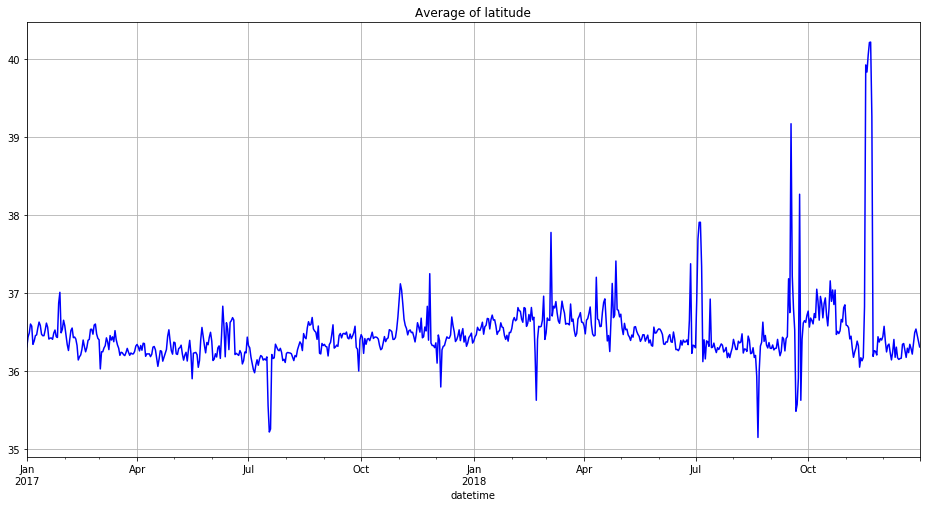

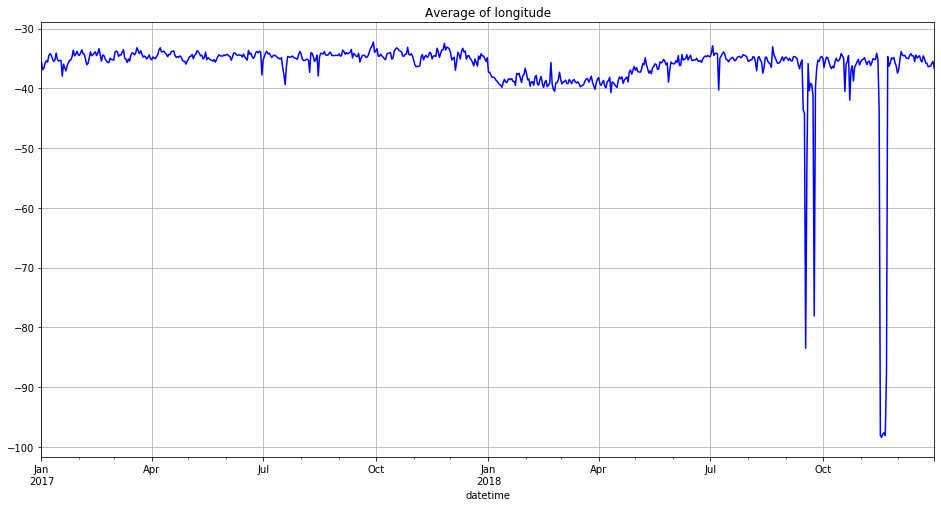

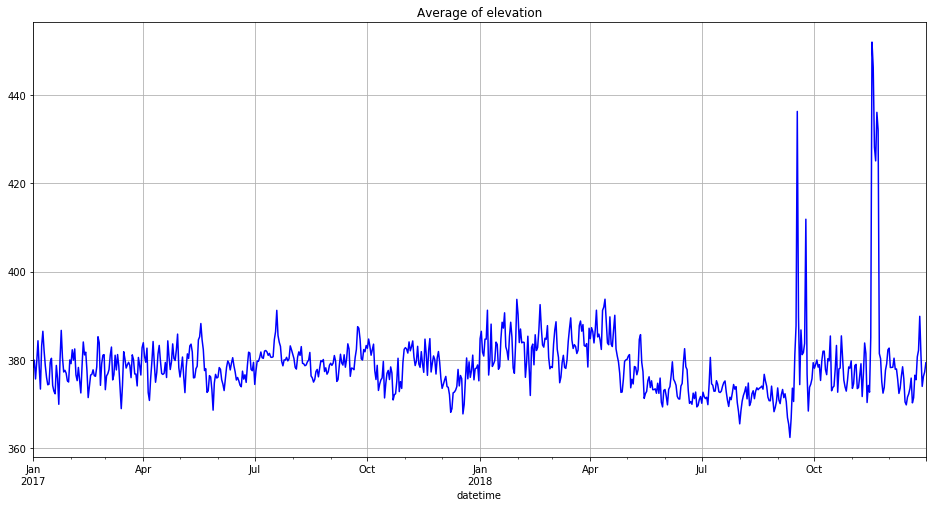

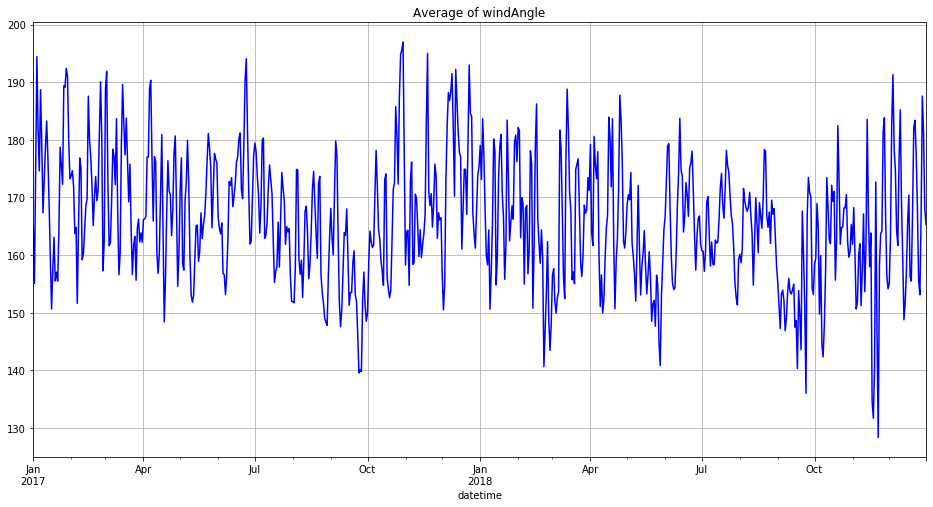

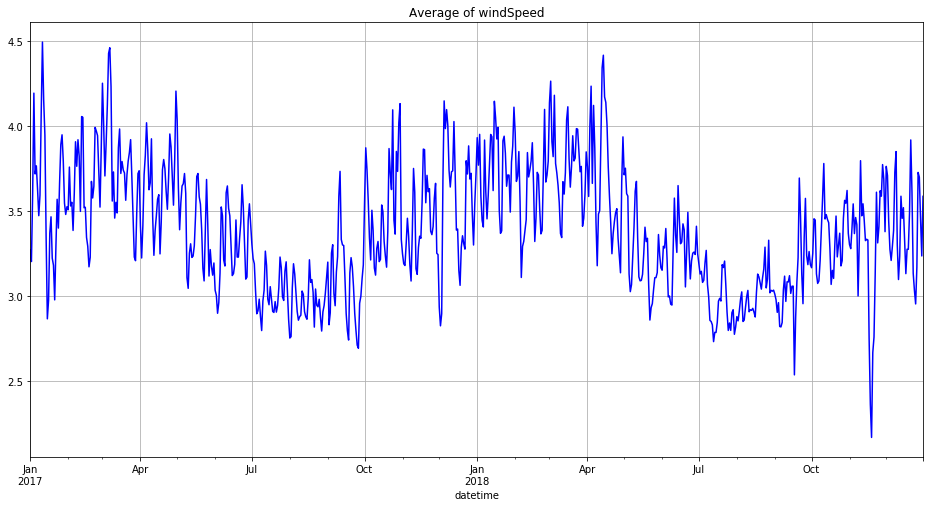

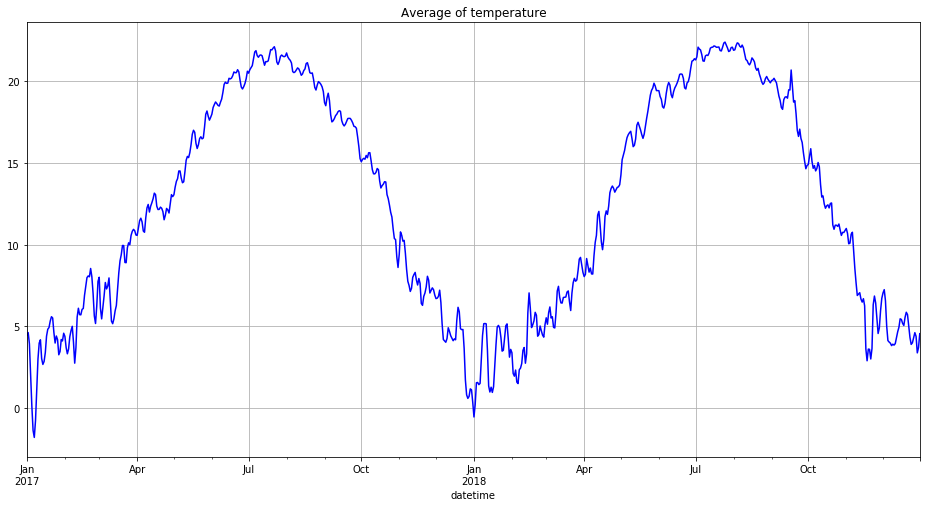

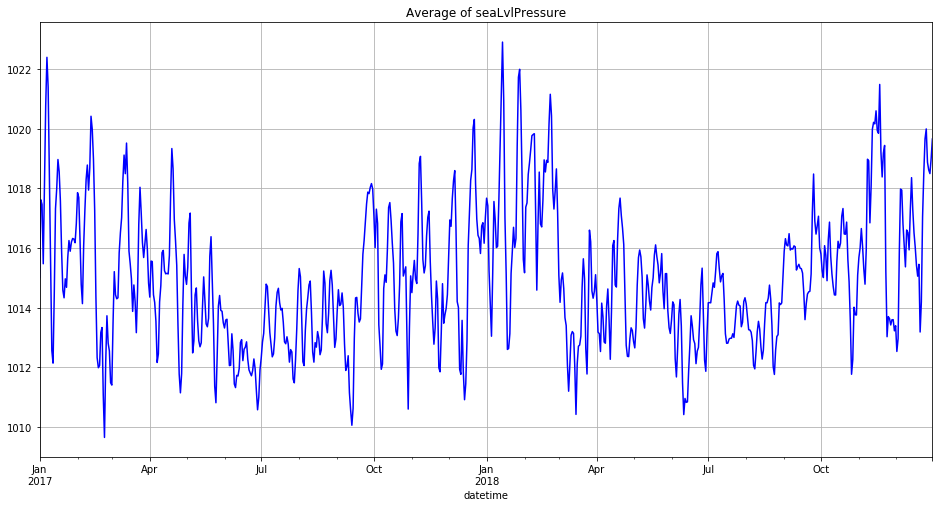

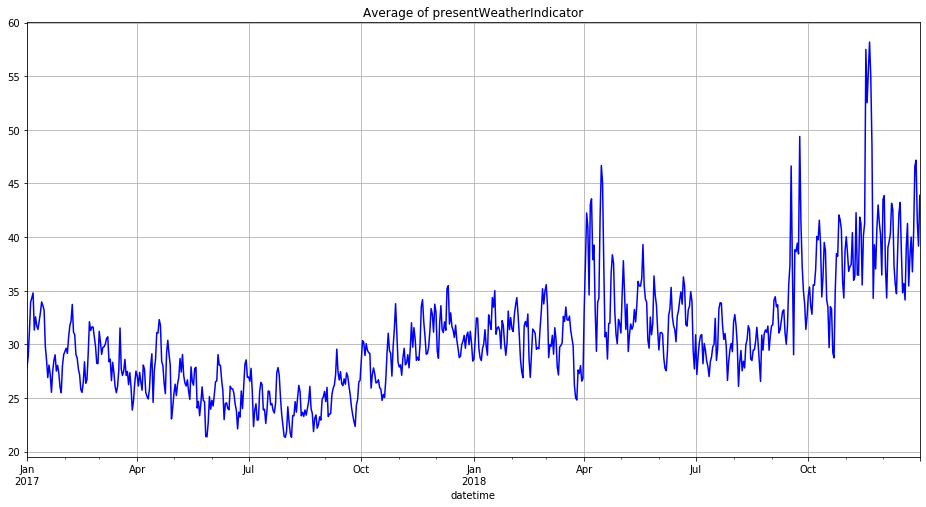

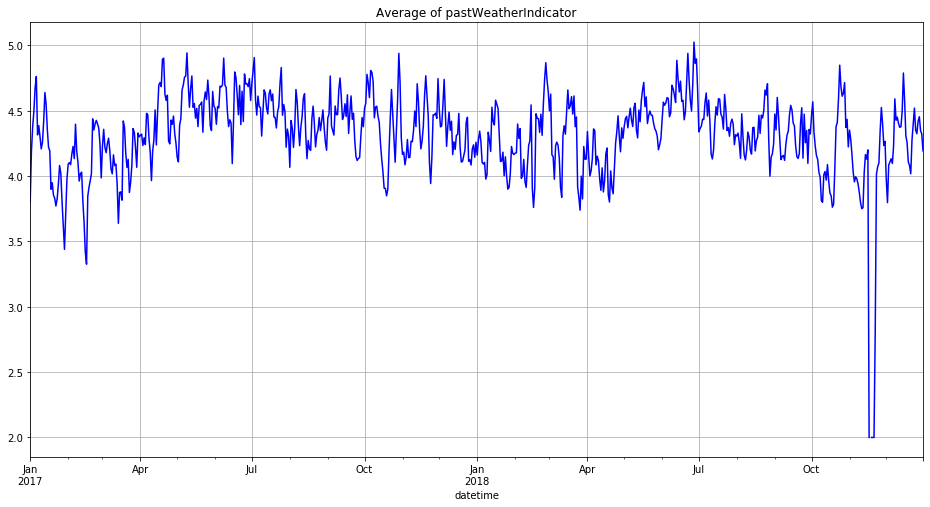

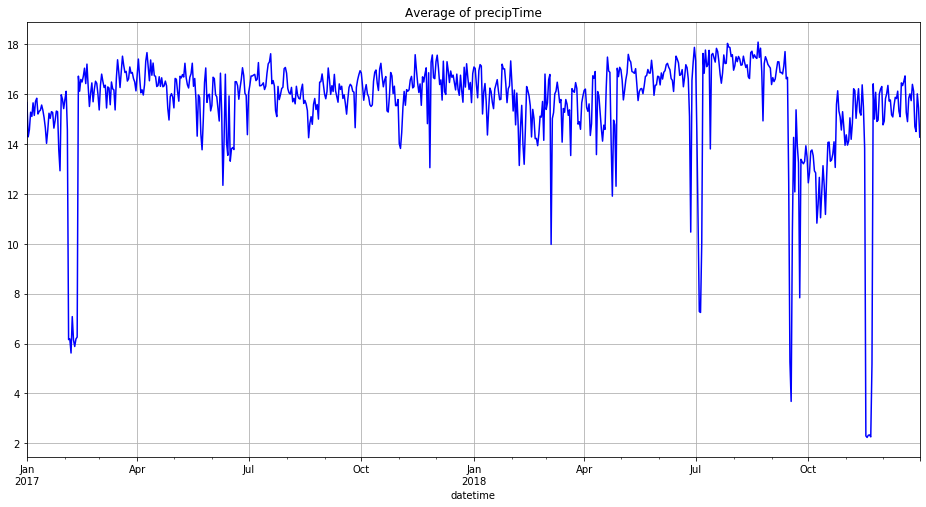

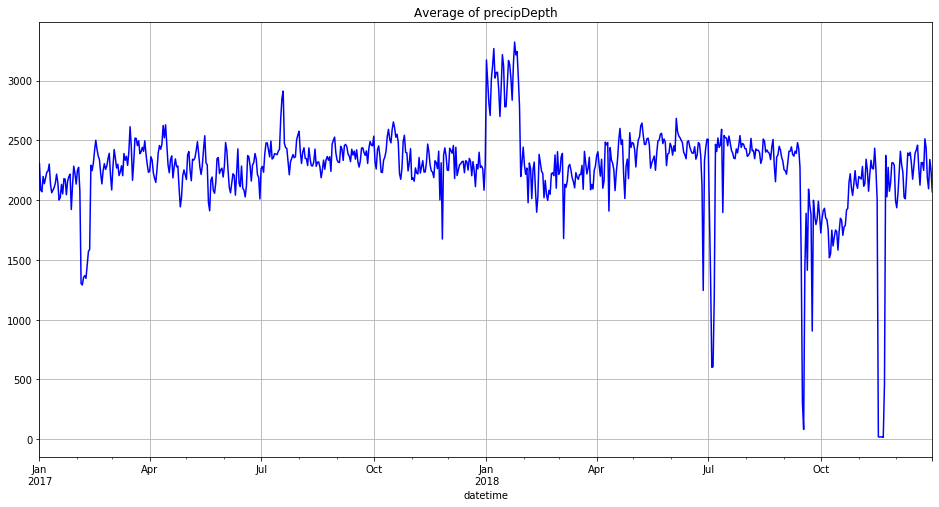

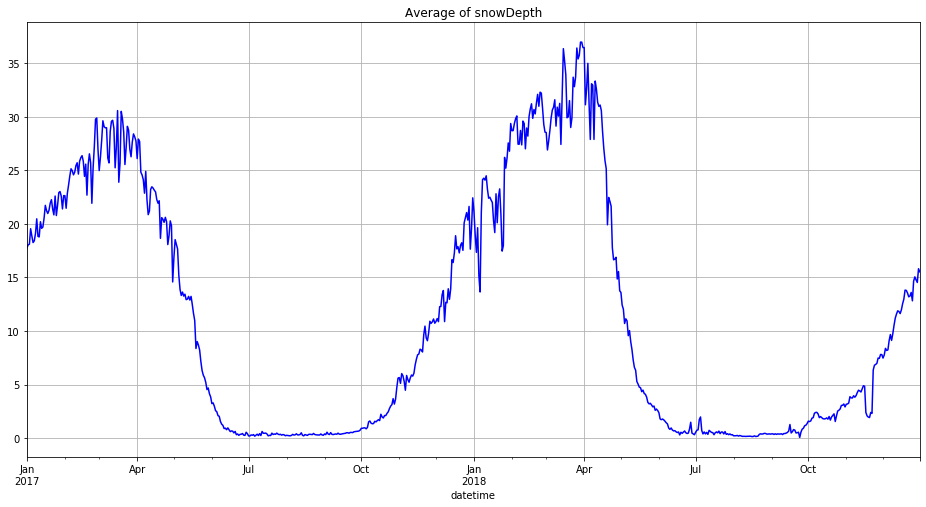

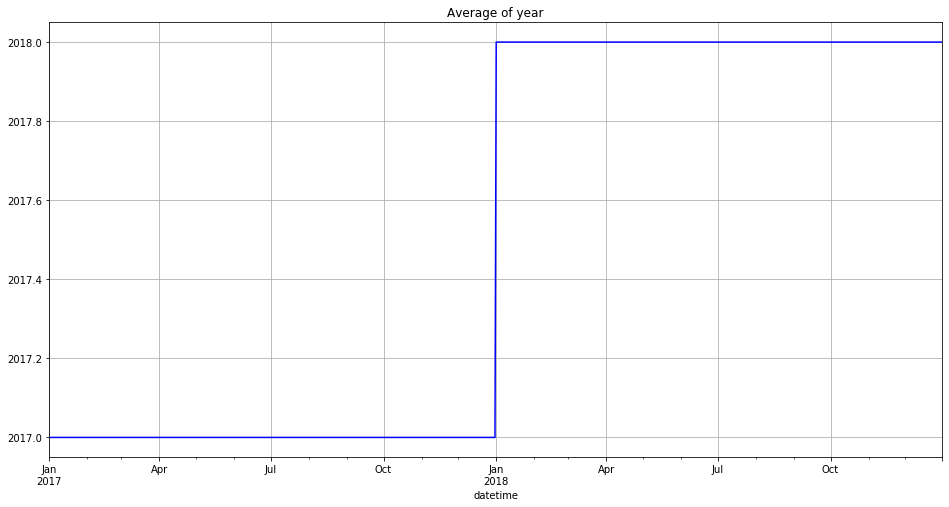

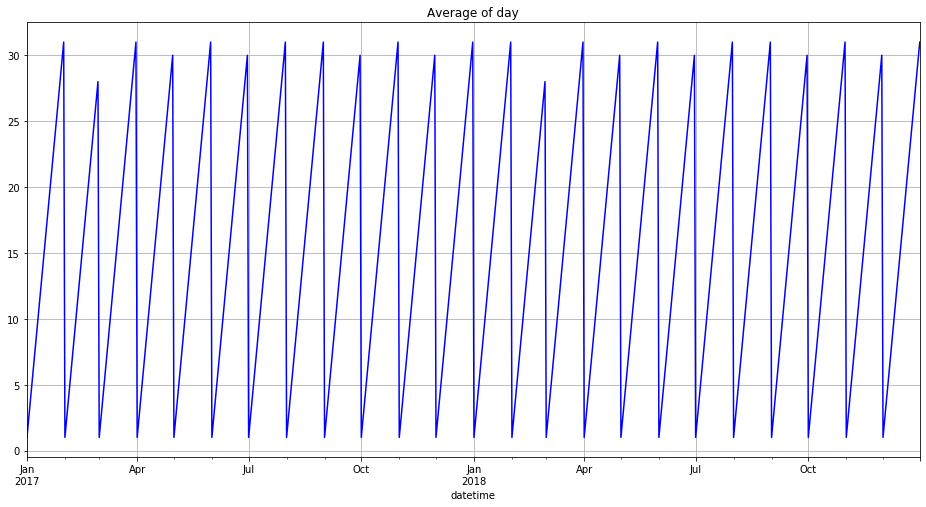

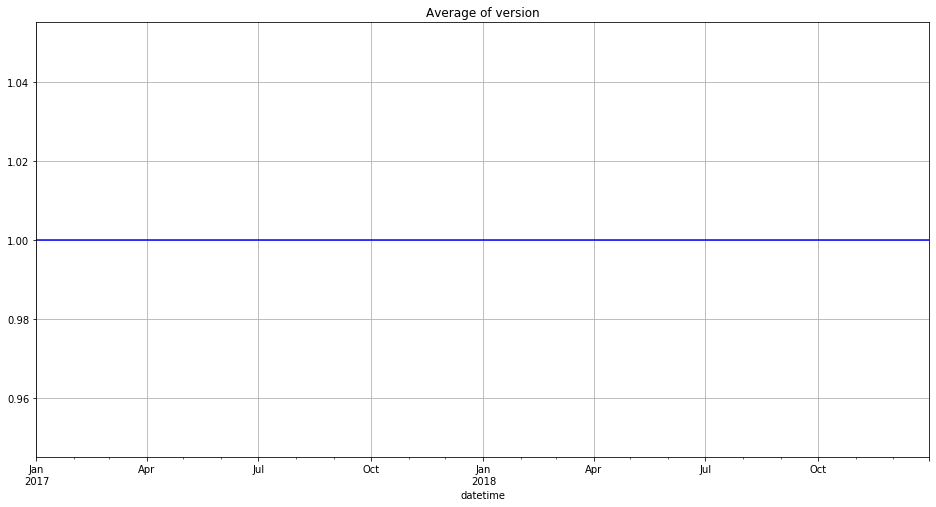

In [23]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(y1, 1, 1), datetime(y2, 12, 31)])
    plt.grid()

In [24]:
c.close()

## Scale up with Dask and Azure ML

In [33]:
exp_name   = 'dask-int'

script_params = {
    '--datastore': ws.get_default_datastore(),
    #'--script'   : 'run.py' # run code in run.py on cluster and teardown (batch processing)
}

est = Estimator('setup', 
                compute_target          = ct, 
                entry_script            = 'start.py',          # sets up Dask cluster
                environment_definition  = env,                 # use same env as local
                script_params           = script_params,       
                node_count              = 60,                  # 20 nodes -> 160 vCPUs, 1 TB RAM
                distributed_training    = MpiConfiguration()
               )

#run = next(ws.experiments[exp_name].get_runs()) # use this to get existing run (if kernel restarted, etc)
run = Experiment(ws, exp_name).submit(est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask-int,dask-int_1578428681_8904c230,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [34]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Connect to cluster

In [ ]:
# port to forward the dask dashboard to on the compute instance
# we do not use 8787 because it is already in use 
dashboard_port = 4242

print("waiting for scheduler node's ip")
while run.get_status() != 'Canceled' and 'scheduler' not in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

if run.get_status() == 'Canceled':
    print('Run was canceled')
else:
    print(f'Setting up port forwarding...')
    os.system(f'killall socat') # kill all socat processes - cleans up previous port forward setups 
    os.system(f'setsid socat tcp-listen:{dashboard_port},reuseaddr,fork tcp:{run.get_metrics()["dashboard"]} &')
    print(f'Cluster is ready to use.')

c = Client(f'tcp://{run.get_metrics()["scheduler"]}')

print(f'\n\n{c}')

c.restart()

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')

### Take all the data

There is an issue with 2019 still working through, ignore it for now.

In [ ]:
# adjust amount of data as needed
y1 = 2008
y2 = 2018
# build list of files 
files = [f'{abfs_path}/year={year}/month={m}/*.parquet' for year in range(y1, y2+1) for m in range(1, 12+1)]

In [ ]:
df = dask.delayed(dd.read_parquet)(files, engine='pyarrow', storage_options=STORAGE_OPTIONS).compute()
%time df.head()

In [ ]:
df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False).persist() # persist and sort data by day 
%time len(df)

In [ ]:
%time len(df)

In [ ]:
%time df.describe().compute()

In [ ]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

In [ ]:
%time means = df.groupby(df.index).mean().compute()
means.head()

In [ ]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(y1, 1, 1), datetime(y2, 12, 31)])
    plt.grid()
    
    # optionally, log the image to the run
    run.log_image(f'mean_{col}', plot=plt)

In [ ]:
run

## Prepare data

In [ ]:
## insert any Pandas-like Dask data prep code 
df['temperature'] = df['temperature']*(9/5)+32       # 'Merica

## Write data

**Important:** you will have not access to write to this account, get your own storage account! 

See the [API documentation for dask.dataframe.to_parquet](https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.to_parquet) for additional settings like specifying columns for directory-based partitioning. 

In [ ]:
%time df = dask.delayed(df.to_parquet)(f'abfs://outputs/noaa/isd_out.parquet', compression='lz4', storage_options=STORAGE_OPTIONS).compute()

## End the run

Cluster will return to 0 nodes

In [ ]:
c.close()
run.cancel()

## Submit a batch job (WIP)

Now that we know what data processing we want to do, let's do it in a batch instead of interactively. 

In [ ]:
%%writefile setup/run.py

import time
import dask
import dask.dataframe as dd

from azureml.core import Run
from dask.distributed import Client

STORAGE_OPTIONS = {
    'account_name': Run.get_context().experiment.workspace.get_default_keyvault().get_secret('daskdataaccount'), 
    'account_key' : Run.get_context().experiment.workspace.get_default_keyvault().get_secret('daskdatakey')
}

c = Client(f'tcp://localhost:8786')

Run.get_context().log('client', c)

t1 = time.time()
### add any Pandas-like Dask data prep code

computes = [] # add any delayed funcitons to compute to this

df = dd.read_parquet(f'abfs://datasets/noaa/isd/isd_out.parquet', storage_options=STORAGE_OPTIONS)
computes = [df.describe(), df.groupby(df.index).mean(), df.memory_usage(index=True, deep=True).sum()]

# compute all in parallel

dask.compute(computes)

### end data prep code
t2 = time.time()

Run.get_context().log('compute_time', dask.utils.format_time(t2-t1))

In [ ]:
exp_name   = 'dask-batch'

script_params = {
    '--datastore': ws.get_default_datastore(),
    '--script'   : 'run.py' # run code in run.py on cluster and teardown (batch processing)
}

est = Estimator('setup', 
                compute_target          = ct, 
                entry_script            = 'start.py',          # sets up Dask cluster
                environment_definition  = env,                 # use same env as local
                script_params           = script_params,       
                node_count              = 20,                  # 20 nodes -> 160 vCPUs, 1 TB RAM
                distributed_training    = MpiConfiguration()
               )

run = Experiment(ws, exp_name).submit(est)
run

In [ ]:
RunDetails(run).show()